# **Modeling**

#### **Import Packages**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier

import torch 
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from tqdm import tqdm

plt.style.use('dark_background')

#### Set Directory

In [3]:
# Change the directory to capstone 2
os.chdir(r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2')

#### **Load the Data**

In [4]:
# Import the small training set
small_train = pd.read_csv('./data/processed/small_train.csv')

# Import the small test set
small_test = pd.read_csv('./data/processed/small_test.csv')

# Import the small training set
big_train = pd.read_csv('./data/processed/big_train.csv')

# Import the small test set
big_test = pd.read_csv('./data/processed/big_test.csv')


Now that I have loaded the datasets, I need to separate out the features (X) from the target variable (y) so that it is easy to run the models. 

In [5]:
# Create the X which is only features in the training data
X_small = small_train.drop(['labels', 'group'], axis = 1)
# Create X small for the test set
X_small_test = small_test.drop(['labels', 'group'], axis = 1)
# Do the same thing for the bigger data set
X_big = big_train.drop(['labels', 'group'], axis = 1)
# Create X big for the test set
X_big_test = big_test.drop(['labels'], axis = 1)
# Create the binary y for the training set.
y_train = np.where(small_train['labels'] == 'normal.', 0, 1)
# Create the binary y for the test set
y_test = np.where(small_test['labels'] == 'normal.', 0, 1)

### **Neural Network**

I wanted to use a gpu for my neural network to speed up the processing significantly. I first tried keras since that is the simplest API for machine learning in Python. Unfortunately Tensorflow has discontinued support for Windows so I would have to find a lot of older versions of many of the packages in this environment just to get a tensorflow version my gpu can use. 

I didn't give up. If tensorflow wasn't going to use Windows I could still use linux. I installed Windows Subsystem for Linux (WSL) and tried a remote session with VScode to use tensorflow gpu. After many failed attempts I was able to get my gpu to run the neural networks with tensorflow in the Linux distribution in WSL. Sadly that took significantly longer to run than tensorflow on the cpu in windows. 

My last hope was to try pytorch on Windows since pytorch hasn't discontinued Windows support. I don't know how to use pytorch well but I have all the code from the keras API that I asked chatGPT to translate into Keras. After wrangling those translations, I found a way to run the neural net on the gpu and it is way faster.

In [16]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("GPU is available")
else:
    device = torch.device("cpu")  # Use the CPU
    print("GPU is not available, using CPU")

GPU is available


In [17]:
torch.device("cuda")

device(type='cuda')

In [19]:
# Create a train and test data from the full dataset
X_train, X_test, y_tr, y_te = train_test_split(X_small, y_train, test_size = .25, random_state = 42)

# Define the model class
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 12)
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 12)
        self.fc4 = nn.Linear(12, 12)
        self.fc5 = nn.Linear(12, 8)
        self.fc6 = nn.Linear(8, 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.sigmoid(self.fc6(x))
        return x

# Create an instance of the model
model = Net(X_train.shape[1])

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Convert the data to torch tensors and move to the GPU
X_train_tensor = torch.Tensor(X_train.values).float().to(device)
y_train_tensor = torch.Tensor(y_tr).float().to(device)
X_test_tensor = torch.Tensor(X_test.values).float().to(device)

# Training loop
num_epochs = 10
batch_size = 5000
losses = []
for epoch in range(num_epochs):
    # Shuffle the data at the start of each epoch
    indices = np.random.permutation(len(X_train_tensor))
    shuffled_X = X_train_tensor[indices]
    shuffled_y = y_train_tensor[indices]
    
    # Set the model to training mode
    model.train()

    # Mini-batch training
    for i in range(0, len(X_train_tensor), batch_size):

        batch_X = shuffled_X[i:i+batch_size]
        batch_y = shuffled_y[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X)
        outputs = outputs.view(-1)
        loss = criterion(outputs, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        predicted_labels = (outputs > 0.5).float()
        accuracy = (predicted_labels == batch_y).float().mean()
    

        # Print loss and accuracy
        print(f'\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(X_train_tensor)}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}', end = '\r')
    
    losses.append(loss.item())
        


In [20]:
# Set the model to evaluation mode
model.eval()

# Move the model and data back to the CPU
model.to("cpu")
X_test_tensor = X_test_tensor.to("cpu")

# Perform predictions on the test set
with torch.no_grad():
    preds = model(X_test_tensor)

# Convert the predictions tensor to a numpy array
preds = preds.numpy()

# Classify the predicitions as 0 or 1 since the values the sigmoid produces are not exact
preds = np.where(preds < .5, 0, 1)

# Print the classification report 
print(classification_report(y_te, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    243103
           1       1.00      1.00      1.00    981505

    accuracy                           1.00   1224608
   macro avg       1.00      1.00      1.00   1224608
weighted avg       1.00      1.00      1.00   1224608



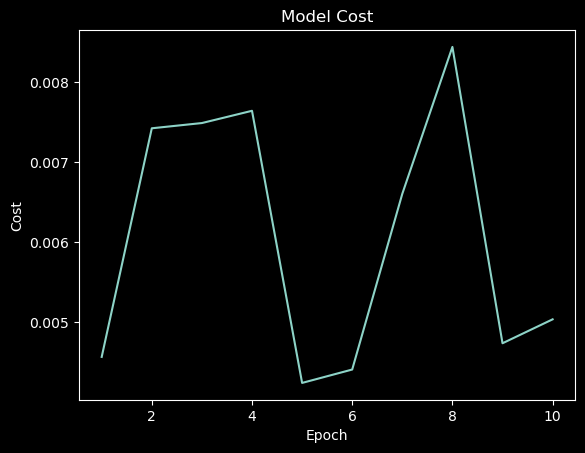

In [21]:
plt.plot(range(1,11), losses);
plt.xlabel("Epoch");
plt.ylabel("Cost");
plt.title("Model Cost");

#### **Small Data**

The first model that I'm going to run is going to use only the training data and using train_test_split to create the test set. Because the official test set contains new values, I want to see how well the data and the model perform when they are only using the type of data that they have been trained for. This in a sense is cross validation because I can still go back and change the model based on this result.

In [22]:
# Create a train and test data from the full dataset
X_train, X_test, y_tr, y_te = train_test_split(X_small, y_train, test_size = .25, random_state = 42)

# Initialize the model
nnettrain = Sequential()

# Create the first layer of the deep learning model with input set the number of features in X_train
nnettrain.add(Dense(12, activation = 'relu', input_dim = X_train.shape[1]))
# Add a middle layer to give the model more complexity
nnettrain.add(Dense(12, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnettrain.add(Dense(12, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnettrain.add(Dense(12, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnettrain.add(Dense(8, activation = 'relu'))
# Finish on a single node with sigmoid activation so that the result is between 0 and 1
nnettrain.add(Dense(1, activation = 'sigmoid'))

# Compile the network with the standard optimiizer and loss function
nnettrain.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

# Train the model whle converting X_train and y_train into floats. Given the accuracy 3 epochs is good enough
nnettrain.fit(X_train.astype('float32'), y_tr.astype('float32'), epochs = 10, batch_size = 5000)



Epoch 1/10


KeyboardInterrupt: 

In [9]:
# Create the predictions
preds = nnettrain.predict(X_test)

# Classify the predicitions as 0 or 1 since the values the sigmoid produces are not exact
preds = np.where(preds < .5, 0, 1)
# Print the classification report 
print(classification_report(y_te, preds))

38269/38269 [==============================] - 68s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    243103
           1       1.00      1.00      1.00    981505

    accuracy                           1.00   1224608
   macro avg       0.99      1.00      1.00   1224608
weighted avg       1.00      1.00      1.00   1224608



This is an incredible result. The model was able to perfectly predict if there was an intrusion in the test set every single time. This may in part be due to luck as some of the rarer intrusion types might not have been in the test set.

With this result I'm now going to try and use this model on the test set to see if we can get the same results as cross validation with the training set.

In [18]:
# Create the predictions for the test result
preds_of = nnettrain.predict(X_small_test)

# Classify the predicitions as 0 or 1 since the values the sigmoid produces are not exact
preds_of = np.where(preds_of < .5, 0, 1)
# Print the classification report
print(classification_report(y_test, preds_of))

9720/9720 [==============================] - 10s 1ms/step
              precision    recall  f1-score   support

           0       0.72      0.86      0.78     60592
           1       0.96      0.92      0.94    250436

    accuracy                           0.91    311028
   macro avg       0.84      0.89      0.86    311028
weighted avg       0.92      0.91      0.91    311028



Unfortunately the model was significantly less than perfect with the official test set. This is in part because there are a lot of new intrusion types that the model couldn't train for. My theory is that the model found patterns that predicted the training intrusions but never found a generalizable pattern for normal observations. Once the intrusions changed the model struggled to keep up with the new information.

It is also important to remember that there is an uneven distribution between intrusions and non intrusions. Below I calculated the percentage of the test set that had intrusions in it.

In [19]:
# Store the unique values and their counts in separate variables
vals, counts = np.unique(y_test, return_counts = True)
# Create value_counts(normalize=True) for np array
prop_counts = counts/len(y_test)
# print the % of observations with no intrusion
print(f'No Intrusion: {round(prop_counts[0]*100, 1)}%')
# print the % of observations with an intrusion
print(f'Intrusion: {round(prop_counts[1]*100,1)}%')

No Intrusion: 19.5%
Intrusion: 80.5%


Above we see that only 19.5% of the test set contains no intrusion so If I had built a model that always predicted intrusion, It would have been high on precision and recall for 1 and very low for zero. The accuracy scores show that this model is providing important value as they would be 50 if the model guessed intrusion every time. It is also important to note that the test set contains new intrusion types that aren't like the training set. Given the very high training scores, if I had a dataset that didn't have the new intrusion types this model would have been nearly perfect.

To get a better understanding of how well the model performed at predicting normal observations I can use the Reciever under the Curve metric which measures the True Positive Rate (TPR) against the False Positive Rate (FPR). A ROC area of greater that 0.8 is good and an ROC curve of 0.9 or greater is excellent.

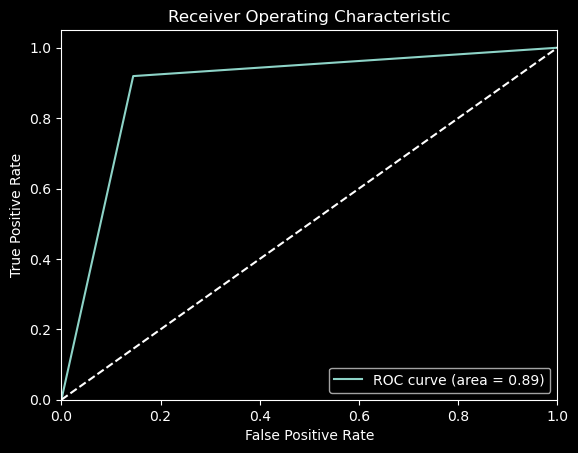

In [34]:
# compute the false positive rate, true positive rate, and threshold for normal observations
fpr, tpr, thresholds = roc_curve(y_test, preds_of)

# calculate the AUC
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc);
# Plot the baseline 50-50 dashed line
plt.plot([0, 1], [0, 1], '--', color = 'w');
# Set the x axis limits
plt.xlim([0.0, 1.0]);
# Set the y axis limits
plt.ylim([0.0, 1.05]);
# Label the x-axis
plt.xlabel('False Positive Rate');
# Label the y-axis
plt.ylabel('True Positive Rate');
# Title the plot
plt.title('Receiver Operating Characteristic');
# Create the legend that has the area under the curve
plt.legend(loc="lower right");
# Show the graph
plt.show();

An ROC curve of .89 is really good although not great. Given the disparity between the official testset and the unofficial testset, it is important to see how the model did when the observations contained the new attack types. 

In [42]:
# Create a list of all the new attack types. This list was taken from preprocessing notebook
new_attacks = ['xsnoop.', 'udpstorm.', 'mscan.', 'named.', 'processtable.', 'xlock.', 'snmpgetattack.', 
               'snmpguess.', 'worm.', 'ps.', 'httptunnel.', 'sendmail.', 'saint.', 'mailbomb.', 'apache2.', 'xterm.', 'sqlattack.']
# Create a mask for all values that are in new attacks in the test set
mask = small_test['labels'].isin(new_attacks)
# Use the mask to find all the y-test values that are from new labels
y_test_new = y_test[mask]
# Use the mask to find all the prediction values that are from new labels
preds_new = preds_of[mask]
# Print the classification report
print(classification_report(y_test_new, preds_new, zero_division = 0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.13      0.24     18729

    accuracy                           0.13     18729
   macro avg       0.50      0.07      0.12     18729
weighted avg       1.00      0.13      0.24     18729



This is not the result that I hoped for. Out of all the observations that had new attack types only 13% of the time the model classified those as attack types. We can see which attack types the model was best at predicting.

In [73]:
# create a dataframe that is a column of labels that only has the new labels
new_labels = pd.DataFrame(small_test['labels'][mask], columns = ['labels']).reset_index(drop=True)
# create a dataframe that is a column of labels that only has the predictions
pred_df = pd.DataFrame(preds_new, columns = ['pred']).reset_index(drop=True)
# Combine the labels and the predictions for analysis
new_intrusions = pd.concat([new_labels, pred_df], axis = 1)
# Run value counts when the prediction is positive to see which new intrusions the model captures
new_intrusions.loc[new_intrusions['pred'] == 1, 'labels'].value_counts()

apache2.         793
processtable.    694
saint.           603
mscan.           262
httptunnel.      119
ps.                7
xterm.             5
xlock.             4
xsnoop.            4
sendmail.          4
sqlattack.         2
named.             1
Name: labels, dtype: int64

And which new intrusion types the model was the worst at predicting.

In [74]:
# Run value counts when the prediction is negative to see which new intrusions the model doesn't capture
new_intrusions.loc[new_intrusions['pred'] == 0, 'labels'].value_counts()

snmpgetattack.    7741
mailbomb.         5000
snmpguess.        2406
mscan.             791
saint.             133
processtable.       65
httptunnel.         39
named.              16
sendmail.           13
ps.                  9
xterm.               8
xlock.               5
udpstorm.            2
worm.                2
apache2.             1
Name: labels, dtype: int64

It is interesting that some of the new intrusion types the model totally disregarded where as some of the new intrusion types it did a great job. If this model was operational it would most likely start doing significantly better after it had trained on the new attack types while still giving some protection against attack types that were similar to the training set. 

#### **Categorical Models**

In [78]:
# Create a train and test data from the full dataset
X_train, X_test, y_tr, y_te = train_test_split(X_small, small_train['group'], test_size = .25, random_state = 42)

# Encode the different groups as numeric values
label_encoder = LabelEncoder()
# fit and transform the y training data with label encoder
y_group = label_encoder.fit_transform(y_tr)
# transfrom the encoded data to a categorical variable
y_group = to_categorical(y_group, num_classes = 8)

# Initialize the model
nnettraincat = Sequential()

# Create the first layer of the deep learning model with input set the number of features in X_train
nnettraincat.add(Dense(12, activation = 'relu', input_dim = X_small.shape[1]))
# Add a middle layer to give the model more complexity
nnettraincat.add(Dense(12, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnettraincat.add(Dense(12, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnettraincat.add(Dense(12, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnettraincat.add(Dense(12, activation = 'relu'))
# Finish with the same amount of nodes as categories that there are to predict
nnettraincat.add(Dense(8, activation = 'softmax'))

# Compile the network with the standard optimiizer and loss function
nnettraincat.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# Train the model with X_train and the encoded categorical y_group
nnettraincat.fit(X_train, y_group, epochs = 3, batch_size = 50)
# Create the predictions. This creates an array that has as many columns as potential predictions
preds = nnettraincat.predict(X_test)
# Take the highest prediction as the model's prediction
pred = preds.argmax(axis = 1)
# get the intrusions corresponding to the encoder class.
ints = label_encoder.classes_
# Assign each of the predictions to the group that they correspond to
predictions = [ints[i] for i in pred]
# Print out the classification report
print(classification_report(y_te, predictions, zero_division = 0))

Epoch 1/3
73477/73477 [==============================] - 121s 2ms/step - loss: 0.0120 - accuracy: 0.9970
Epoch 2/3
73477/73477 [==============================] - 122s 2ms/step - loss: 0.0075 - accuracy: 0.9982
Epoch 3/3
38269/38269 [==============================] - 43s 1ms/step
              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00        19
       files       0.00      0.00      0.00         6
    internal       1.00      1.00      1.00    702901
        none       1.00      1.00      1.00    243103
       pings       1.00      1.00      1.00    268035
     scripts       0.00      0.00      0.00         3
      sweeps       0.97      0.90      0.94     10285
       warez       0.00      0.00      0.00       256

    accuracy                           1.00   1224608
   macro avg       0.50      0.49      0.49   1224608
weighted avg       1.00      1.00      1.00   1224608



This continues the earlier model's training perfect results for predicting if there is an intrusion or not. It is important to note that every group over with over 300 observations the model performed very well. Unfortunately the rare groups the model had a lot more trouble with. Given the amount of observations that are in the dataset the model is still clearly giving important information.

In [79]:
# redefine y_group variable as the 'group' column from the test set
y_group = small_test['group']
# Initialize the label encoder
label_encoder = LabelEncoder()
# fit and transform y_group
y_group = label_encoder.fit_transform(y_group)
# Transform the y_group variable to a categorical variable
y_group = to_categorical(y_group, num_classes = 8)

In [80]:
# Predict the test dataset with the previous model
preds = nnettraincat.predict(X_small_test)
# Find the prediction that the model likes the most
pred = preds.argmax(axis = 1)
# Get the corresponding group types from label_encoder
ints = label_encoder.classes_
# find the intrusions for each prediction
predictions = [ints[i] for i in pred]
# Print the classification report
print(classification_report(small_test['group'], predictions, zero_division = 0))

9720/9720 [==============================] - 10s 1ms/step
              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00      7574
       files       0.00      0.00      0.00         5
    internal       0.96      0.99      0.98    165217
        none       0.69      0.89      0.78     60592
       pings       0.98      0.91      0.94     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.55      0.50      0.52      4166
       warez       0.00      0.00      0.00      1602

    accuracy                           0.89    311028
   macro avg       0.40      0.41      0.40    311028
weighted avg       0.85      0.89      0.87    311028



This is a horrible result as the none group had a significant reduction in precision. It is important to realize that the model was able to correctly identify 89% of the normal observations but there were a lot of false positives. I'm sure that there are a lot of ways to optimize the model that would better capture what is an intrusion and what is not.

#### **Big Data**

Now is the chance to use the bigger dataset that is supposed to contain every features that can help distinguish between the intrusion types.

In [87]:
# Create a train and test data from the full dataset
X_train, X_test, y_tr, y_te = train_test_split(X_big, small_train['group'], test_size = .25)

# Initialize the label encoder
label_encoder = LabelEncoder()
# fit and transform the y training data with label encoder
y_group = label_encoder.fit_transform(y_tr)
# transfrom the encoded data to a categorical variable
y_group = to_categorical(y_group, num_classes = 8)

# Initialize the model
nnetbigcat = Sequential()

# Create the first layer of the deep learning model with input set the number of features in X_train
nnetbigcat.add(Dense(61, activation = 'relu', input_dim = X_big.shape[1]))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(61, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(61, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(61, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(61, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(61, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(61, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(61, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(61, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(53, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(38, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(25, activation = 'relu'))
# Add a middle layer to give the model more complexity
nnetbigcat.add(Dense(14, activation = 'relu'))
# Finish with the same amount of nodes as categories that there are to predict
nnetbigcat.add(Dense(8, activation = 'softmax'))
# Compile the network with the standard optimiizer and loss function
nnetbigcat.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
# Train the model with X_train and the encoded categorical y_group
nnetbigcat.fit(X_train.astype('float32'), y_group, epochs = 2, batch_size = 50)
# Create the predictions. This creates an array that has as many columns as potential predictions
preds = nnetbigcat.predict(X_test)
# Take the highest prediction as the model's prediction
pred = preds.argmax(axis = 1)
# get the intrusions corresponding to the encoder class.
ints = label_encoder.classes_
# Assign each of the predictions to the group that they correspond to
predictions = [ints[i] for i in pred]
# Print out the classification report
print(classification_report(y_te, predictions, zero_division = 0))

              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00        19
       files       0.00      0.00      0.00         3
    internal       1.00      1.00      1.00    703507
        none       1.00      1.00      1.00    242578
       pings       1.00      1.00      1.00    267962
     scripts       0.00      0.00      0.00         4
      sweeps       0.99      0.98      0.98     10290
       warez       0.00      0.00      0.00       245

    accuracy                           1.00   1224608
   macro avg       0.50      0.50      0.50   1224608
weighted avg       1.00      1.00      1.00   1224608



This was slightly more precise than the previous model where the sweeps group was nearly perfect. Now lets see how it performs on the official test set.

In [88]:
# Predict the test dataset with the previous model
preds = nnetbigcat.predict(X_big_test)
# Find the prediction that the model likes the most
pred = preds.argmax(axis = 1)
# Get the corresponding group types from label_encoder
ints = label_encoder.classes_
# find the intrusions for each prediction
predictions = [ints[i] for i in pred]
# Print the classification report
print(classification_report(small_test['group'], predictions, zero_division = 0))

9720/9720 [==============================] - 14s 1ms/step
              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00      7574
       files       0.00      0.00      0.00         5
    internal       0.97      1.00      0.99    165217
        none       0.71      0.92      0.80     60592
       pings       0.98      0.92      0.95     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.77      0.68      0.72      4166
       warez       0.00      0.00      0.00      1602

    accuracy                           0.91    311028
   macro avg       0.43      0.44      0.43    311028
weighted avg       0.87      0.91      0.88    311028



Overall the neural networks were amazing at predicting intrusion types that had already happened. If this model was to be used at a security firm than the more diverse set of intrusions that it was allowed to train on the better it would do. Unfortunately there are a set of attacks that without training data is impossible for this model to catch. I don't know if there is a better way to train the model to catch them.

The one thing that I wish I had done better was to get the model to generate more rare events. Given the size of the dataset and the rarety of some of the intrusion types the models just ignored those types and stuck with the more common intrusion types. If I had weighted the model and created some synthetic data with some of the rarer intrusion types that might have helped the model predict all intrusion types.

### **Random Forrest**

The second type of model that I will use is random forrest which is an ensemble method of decision trees. The idea is that since hacking is an inherently human act, the process should follow some sort of decision tree where certain features being elevated or lowered should lead to certain types of intrusions. I did not have enough time to conduct a grid search or random search so I just did the basic version of a Random Forest Classifier.

In [7]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state= 42)

# Fit the model to the data
rf.fit(X_small, y_train)

# Predict the test set
rf_pred = rf.predict(X_small_test)

# print the classification report
print(classification_report(y_test, rf_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77     60592
           1       0.96      0.91      0.94    250436

    accuracy                           0.90    311028
   macro avg       0.83      0.89      0.85    311028
weighted avg       0.91      0.90      0.90    311028



This is slightly worse than the neural network but it is very close. It could be that If the hyper parameters were correctly tuned that the results would be better. Below is a categorical random forrest.

In [ ]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state= 42)

# Fit the model to the data
rf.fit(X_small, y_group)

# Predict the test set
rf_pred_group = rf.predict(X_small_test)

In [12]:
# Predict the test dataset with the previous model
preds = rf.predict(X_small_test)
# Find the prediction that the model likes the most
pred = preds.argmax(axis = 1)
# Get the corresponding group types from label_encoder
ints = label_encoder.classes_
# find the intrusions for each prediction
predictions = [ints[i] for i in pred]
# Print the classification report
print(classification_report(small_test['group'], predictions, zero_division = 0))

              precision    recall  f1-score   support

 brute force       0.01      0.01      0.01      7574
       files       0.00      0.00      0.00         5
    internal       0.82      0.80      0.81    165217
        none       0.54      0.99      0.70     60592
       pings       0.94      0.28      0.43     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.20      0.50      0.29      4166
       warez       0.00      0.00      0.00      1602

    accuracy                           0.68    311028
   macro avg       0.31      0.32      0.28    311028
weighted avg       0.74      0.68      0.66    311028



This did significantly worse than the neural network. It is important to note that it recalled 99% of all the non intrusion observations but its precision was so low that has much less importance than the recall would indicate.

Below is the same but with the bigger dataset.

In [93]:
# Initialize the label encoder
label_encoder = LabelEncoder()
# fit and transform y_group
y_group = label_encoder.fit_transform(small_train['group'])
# Transform the y_group variable to a categorical variable
y_group = to_categorical(y_group, num_classes = 8)


# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state= 42)

# Fit the model to the data
rf.fit(X_big, y_group)

# Predict the test dataset with the previous model
preds = rf.predict(X_big_test)
# Find the prediction that the model likes the most
pred = preds.argmax(axis = 1)
# Get the corresponding group types from label_encoder
ints = label_encoder.classes_
# find the intrusions for each prediction
predictions = [ints[i] for i in pred]
# Print the classification report
print(classification_report(small_test['group'], predictions, zero_division = 0))


              precision    recall  f1-score   support

 brute force       0.05      0.42      0.09      7574
       files       0.00      0.00      0.00         5
    internal       0.53      0.00      0.00    165217
        none       0.21      0.78      0.34     60592
       pings       0.98      0.28      0.43     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.76      0.76      0.76      4166
       warez       1.00      0.13      0.23      1602

    accuracy                           0.23    311028
   macro avg       0.44      0.30      0.23    311028
weighted avg       0.54      0.23      0.17    311028



## **Conclusion**

From these results it is clear that the neural network model is the best model. With more time I could run a lot of hyper paramater tuning and investigate if taking the highest value soft max is the best decision or if maybe sometimes the model hints at something rarer that gets covered up by higher values of more common types. But until then the best model was the big data categorical model. It recalled 92% of all non intrusion observations and 71% precision while also giving valuable insight into the type of intrusion it was. This means that when the model predicted that there was an intrusion there was a 1-(.195*(1-.92)) = 98.4% chance that there was an intrusion.